# Homework 03 - Part 2 : Map Viz


_Goal_ :

**We have data describing the grants in Switzerland in the `grants_summary.csv` file. Now, we want to build some map viz to see how much money each canton gets. We will use *Folium* to do so.**

_Tools_ :

**The tools used for this part are :**
* Folium
* Interact (for bonus widget)

_Content_ :
* [0 - Maps with Folium](#0---Maps-with-Folium)
* [1 - Choropleth map for all grants and for all years](#1---Choropleth-map-for-all-grants-and-for-all-years)
* [2 - BONUS - Rostigraben](#2---BONUS---Rostigraben)
* [3 - EXTRA - Adding markers for universities](#3---EXTRA---Adding markers for universities)
* [4 - EXTRA - Data across years](#4---EXTRA---Data-across-years)

---

First, we make some useful and usual imports.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
sns.set_context('notebook')

# 0 - Maps with *Folium*

First, we can try to create an "empty" *Folium* map, centered on Switzerland.

We have at our disposal a *TopoJSON* file, which describes the cantons topology. Let's first visualize them, using the `choropleth` method. For the moment, all cantons appear with the same color since no data is used to differentiate them.

In [4]:
topo_path = r'ch-cantons.topojson.json' # TopoJSON file path

swissmap = folium.Map(location=[46.8629761,8.2431788], tiles='Mapbox Bright', zoom_start=8)
swissmap.choropleth(geo_path=topo_path, topojson='objects.cantons', fill_color='red')
swissmap

# 1 - Choropleth map for all grants and for all years

Now, we want to create a map that shows intuitively how much grant money goes to each Swiss canton. Let's first load *all* the cantons codes from the `cantons.csv` file. (*NB : This step is necessary since in the grants data, not all cantons are present*).

In [5]:
cantons = pd.read_csv('cantons.csv', usecols=['canton'])
cantons.head()

,canton
0,ZH
1,BE
2,LU
3,UR
4,SZ


Then, we can load our data which has been exported to the `grants_summary.csv` file. We group the data by canton and apply the `sum` function (note that we drop the `year` column since it's no longer meaningful). **Finally, we divide the amounts by a million to have more readable ones**.

In [6]:
cols = ['university', 'amount', 'year', 'address', 'latitude', 'longitude', 'canton']
grants_df = pd.read_csv('grants_summary.csv', usecols=cols)
grants_cantons = grants_df.groupby('canton', as_index=False).sum()
grants_cantons = grants_cantons.drop(['year', 'latitude','longitude'], axis=1)
grants_cantons.columns = ['canton', 'amount']
grants_cantons.amount = round(grants_cantons.amount / 1e6, 3)
grants_cantons.head()

,canton,amount
0,AG,126.188
1,BE,1555.148
2,BS,1392.498
3,FR,459.074
4,GE,1877.102


The last step consists in merging the two dataframes `cantons` and  `grants_cantons` and replacing NA values by 0. This way, we have data for *all* swiss cantons, even for those without any grant. This is mandatory because *folium* can build the map only if the number of elements in the dataframe and in the TopoJSON file are the same.

In [7]:
grants_cantons_df = cantons.merge(grants_cantons, how='outer').fillna(0)
grants_cantons_df.head()

,canton,amount
0,ZH,3655.871
1,BE,1555.148
2,LU,54.673
3,UR,0.000
4,SZ,0.937


Finally, we can display the choropleth map with the *Folium* `choropleth` function, which takes as parameters :
* the TopoJSON data, as we have seen before
* the dataframe containing the data to display
* the names of the columns that we want to display
* the scale
* the color palette to use

In [9]:
thresh = [1,600,1200,1800,2700,3600]
swiss_grants = folium.Map(location=[46.8629761,8.2431788], tiles='Mapbox Bright', zoom_start=8)
swiss_grants.choropleth(
    geo_path=topo_path,
    data=grants_cantons_df,
    columns=['canton', 'amount'],
    key_on='feature.id',
    threshold_scale=thresh,
    fill_color='BuPu', fill_opacity=0.6,
    legend_name='Grants amount (in CHF)',
    topojson='objects.cantons',
    reset=True
)
swiss_grants.save('maps/cantons_grants.html')
swiss_grants

# 2 - BONUS - Rostigraben

We want to give a rough estimate of the difference in research funding between the areas divided by the Röstigraben. First, we scrape a web page containing the languages by canton.

In [10]:
import bs4
import urllib.request as ur

base_url = "http://schweizer-kantone-orte.websieb.info"

# Get the HTML page
req = ur.Request(base_url)
page = ur.urlopen(req).read()

# Build a dataframe from the table containing languages for cantons
cantons_languages = pd.read_html(page, flavor='bs4')[4]
cantons_languages = cantons_languages.loc[:,[3,7]]
cantons_languages = cantons_languages.drop(0)
cantons_languages = cantons_languages.drop(27)
cantons_languages.columns = ['canton', 'language']

def normalize(x):
    split = x.split(',')
    split.sort()
    return ''.join(split)

cantons_languages['language'] = cantons_languages.language.apply(normalize)
cantons_languages.head()

,canton,language
1,AG,d
2,AR,d
3,AI,d
4,BL,d
5,BS,d


Now, we merge the above dataframe with the previous one containing the amounts.

In [11]:
grants_df_lang = pd.merge(grants_cantons_df, cantons_languages, how='inner')
grants_df_lang.head()

,canton,amount,language
0,ZH,3655.871,d
1,BE,1555.148,df
2,LU,54.673,d
3,UR,0.000,d
4,SZ,0.937,d


To make it more visual, we create a map identifying the language in each canton. 

In [12]:
lang_code = {'d': 0, 'i': 0, 'dir': 0, 'f': 2, 'df': 1}
grants_df_lang['lang_code'] = grants_df_lang.language.apply(lambda x: lang_code[x])

swiss_lang = folium.Map(location=[46.8629761,8.2431788], tiles='Mapbox Bright', zoom_start=8)
swiss_lang.choropleth(
    geo_path=topo_path,
    data=grants_df_lang,
    columns=['canton', 'lang_code'],
    key_on='feature.id',
    fill_color='PuBu', fill_opacity=0.6,
    legend_name='Languages in Switzerland',
    topojson='objects.cantons',
    reset=True
)
swiss_lang.save('maps/cantons_langs.html')
swiss_lang

/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


Now, to estimate the difference in funding between the cantons divided by the Röstigraben, we divide the cantons in two groups : east and west. To do so, we make the following assumptions :
* BE is mostly german speaking, so it belongs to the east part
* VS is mostly french, so it belongs to the west part
* FR is mostly french, so it belongs to the west part
* we count the italian speaking cantons as east.

Mind that we use the language column to do this classification.

In [13]:
grants_df_lang.loc[grants_df_lang.canton=='BE', 'language'] = 'd'
grants_df_lang.loc[grants_df_lang.canton=='FR', 'language'] = 'f'
grants_df_lang.loc[grants_df_lang.canton=='VS', 'language'] = 'f'
grants_df_lang.loc[grants_df_lang.language=='dir', 'language'] = 'd'
grants_df_lang.loc[grants_df_lang.language=='i', 'language'] = 'd'

In [14]:
langs_df = grants_df_lang[['canton', 'language']]
langs_df.head()

,canton,language
0,ZH,d
1,BE,d
2,LU,d
3,UR,d
4,SZ,d


Finally, we use `groupby` and `sum` to compute the total amount for each part :

In [15]:
grants_df_lang.groupby('language').sum().drop('lang_code', axis=1)

,amount
language,
d,7075.614
f,5215.747


Let's see if the difference between the two parts is statistically significant. To do so, we use merge and previous dataframes and then run a KS test.

In [16]:
grants_lang_df = pd.merge(grants_df, langs_df)
grants_lang_df.head()

,university,amount,year,address,latitude,longitude,canton,language
0,Université de Genève - GE,41022.0,1975.0,Geneva,46.204391,6.143158,GE,f
1,Université de Genève - GE,360000.0,1975.0,Geneva,46.204391,6.143158,GE,f
2,Université de Genève - GE,116991.0,1975.0,Geneva,46.204391,6.143158,GE,f
3,Université de Genève - GE,149485.0,1975.0,Geneva,46.204391,6.143158,GE,f
4,Université de Genève - GE,164602.0,1975.0,Geneva,46.204391,6.143158,GE,f


In [17]:
grants_grouped = grants_lang_df.groupby(['university', 'language'], as_index=False).sum()
grants_grouped = grants_grouped.drop(['year', 'latitude', 'longitude'], axis=1)
grants_grouped.head()

,university,language,amount
0,AO Research Institute - AORI,d,3435621.0
1,Allergie- und Asthmaforschung - SIAF,d,19169965.0
2,Berner Fachhochschule - BFH,d,31028695.0
3,Biotechnologie Institut Thurgau - BITG,d,2492535.0
4,Centre de rech. sur l'environnement alpin - CR...,f,1567678.0


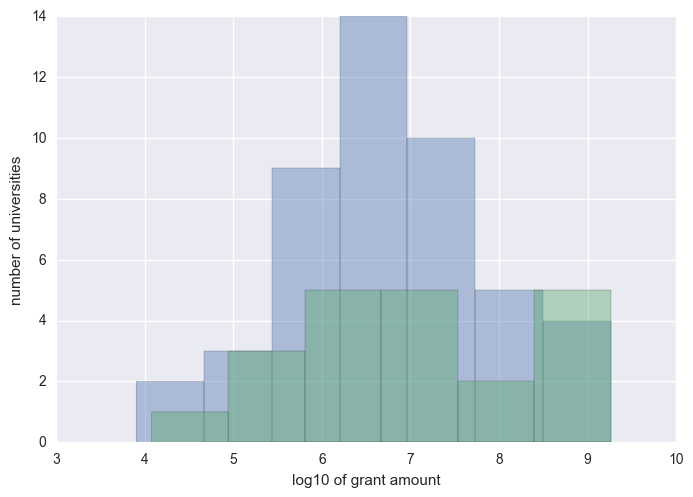

In [18]:
sns.distplot(np.log10(grants_grouped.amount[grants_grouped.language=='d']), kde=False)
sns.distplot(np.log10(grants_grouped.amount[grants_grouped.language=='f']), kde=False)
plt.xlabel('log10 of grant amount')
plt.ylabel('number of universities')

In [19]:
import scipy.stats as stats

grants_f = grants_grouped[grants_grouped.language=='f'].amount
grants_d = grants_grouped[grants_grouped.language=='d'].amount

stats.ks_2samp(grants_f, grants_d)

Ks_2sampResult(statistic=0.15298885511651472, pvalue=0.85673393277128074)

The `pvalue` is bigger than 0.05, we do not reject the null hypothesis, which is basically that the two parts get the same amount of money.

# 3 - EXTRA - Adding markers for universities

Recall that we actually have the position of most of the universities. We can add them on the map as circle markers, with the size of the circle indicating the grants amount.

In [20]:
uni_coord = grants_df.drop(['year', 'address', 'canton'], axis=1)
uni_coord.dropna()
uni_coord = uni_coord.groupby(['university', 'latitude', 'longitude']).sum()

In [25]:
amount_sum = uni_coord.amount.sum()
base_radius = 1e+5
for idx in uni_coord.index:
    legend = "{} -- {} *10^6 CHF".format(idx[0], round(uni_coord.loc[idx].amount/1e6,3))
    #rad = uni_coord.loc[idx].amount/amount_sum * base_radius
    rad = uni_coord.loc[idx].amount / 200000
    folium.CircleMarker(location=[idx[1], idx[2]], radius=rad,
                        popup=legend, color='#3186cc',
                        fill_color='#3186cc').add_to(swiss_grants)

In [26]:
swiss_grants.save('maps/uni_map.html')
swiss_grants

# 4 - EXTRA - Data across years

The data we have covers many years. It can be interesting to visualize the evolution of the grants through time. *However*, mind that this data is partial, and it is likely that old grants will be missing.

First, we put the data in a more practical dataframe, using a group by canton and year.

In [27]:
cols = ['university', 'amount', 'year', 'address', 'latitude', 'longitude', 'canton']
grants_df = pd.read_csv('grants_summary.csv', usecols=cols)
grants_cantons = grants_df.groupby(['canton', 'year'], as_index=False).sum()
grants_cantons = grants_cantons.drop(['latitude','longitude'], axis=1)
grants_cantons.columns = ['canton', 'year', 'amount']
grants_cantons.head()

,canton,year,amount
0,AG,1977.0,132590.0
1,AG,1978.0,374450.0
2,AG,1980.0,97306.0
3,AG,1981.0,531645.0
4,AG,1982.0,195409.0


Now, define a function that retrieves all the data for a single year :

In [28]:
def grants_by_year(grants, cantons, year):
    year_df = grants[grants.year == year]
    year_df.drop('year', axis=1)
    return cantons.merge(year_df, how='outer').fillna(0)

Finally, define a function that takes a year as a parameter, and displays the same kind of map as before but for this year only.

In [35]:
def display_by_year(year):
    df = grants_by_year(grants_cantons, cantons, year)
    swiss_grants = folium.Map(location=[46.8629761,8.2431788], tiles='Mapbox Bright', zoom_start=8)
    swiss_grants.choropleth(
        geo_path=topo_path,
        data=df,
        columns=['canton', 'amount'],
        key_on='feature.id',
        threshold_scale=thresh,
        fill_color='BuPu', fill_opacity=0.6,
        legend_name='Grants amount (in CHF)',
        topojson='objects.cantons',
        reset=True
    )
    return swiss_grants

We can now build a map widget, with a slider to navigate through time (*Great Scott, Marty!*)

In [36]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

min_year = grants_cantons.year.min()
max_year = grants_cantons.year.max()
interact(display_by_year, year=widgets.IntSlider(min=min_year,max=max_year,step=1,value=min_year));